**create data for geocoding**

In [ ]:
orig_file =  "/content/311_s20.csv"
geocode_input = "geocode_input.csv"
split_folder = "/content/splits"

df = pd.read_csv(orig_file)
df.head()
columns = ["case_enquiry_id","location_street_name","neighborhood","location_zipcode"]
temp_df = df[columns]
temp_df['state']="Massachusetts"
temp_df.head()
temp_df.to_csv(geocode_input, index=None, header=False)

<ipython-input-15-4f3e9d997b84>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['state']="Massachusetts"


,case_enquiry_id,location_street_name,neighborhood,location_zipcode,state
0,101004616148,2180 Dorchester Ave,Dorchester,2124.0,Massachusetts
1,101004626775,21 Jersey St,Boston,2215.0,Massachusetts
2,101004617839,111 Winthrop St,Roxbury,2119.0,Massachusetts
3,101004618666,28-32 Fullerton St,Boston,2215.0,Massachusetts
4,101004615805,20 Minot St,Dorchester,2122.0,Massachusetts


**Split the csv files into individual files**

In [ ]:
import pandas as pd
import os

df = pd.read_csv(geocode_input, header = None)
rows_per_file = 5
total_files = len(df) // rows_per_file + 1
for i in range(total_files):
    start_row = i * rows_per_file
    end_row = start_row + rows_per_file
    filename = os.path.join( split_folder+"/file_"+str(i+1)+".csv")
    df_subset = df[start_row:end_row]
    df_subset.to_csv(filename, index=None, header=False)

In [ ]:
# reset the split directory
# !rm -rf /content/splits
# !mkdir /content/splits

**Merge two data frames based on the Id**

In [ ]:
import pandas as pd

file_with_codes = "/content/311_with_codes.csv"

df1 = pd.read_csv('file1.csv')
df2 = pd.read_csv('file2.csv')
# Merge the two dataframes based on the ID
merged_df = pd.merge(df1, df2, on='id')
# Write the merged dataframe to a new CSV file
merged_df.to_csv('merged_file.csv', index=False)


In [ ]:
!cp /content/311_s20.csv /content/311_with_codes.csv

In [ ]:
# !curl --form addressFile=@/content/311_iscsz.csv --form benchmark=Public_AR_Current
# https://geocoding.geo.census.gov/geocoder/locations/addressbatch --output /content/geocoderesult.csv

**work on blocks**

In [ ]:
import pandas as pd
df = pd.read_csv("/content/311_block_csv.csv")
print(df.shape)
df = df[df['BLOCK_ID'].notna()]
# df = df[df['CLOSED_DT'].notna()]
# df.head()
print(df.shape)

(10000, 30)
(7690, 30)


In [ ]:
df["BLOCK_ID"].value_counts()

1002.0    343
1003.0    343
1001.0    335
1000.0    320
2003.0    305
         ... 
2039.0      1
7005.0      1
1055.0      1
3020.0      1
6001.0      1
Name: BLOCK_ID, Length: 175, dtype: int64

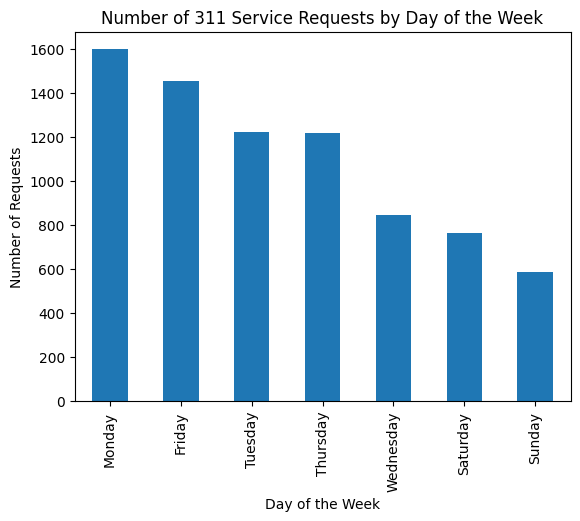

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

#day
df['OPEN_DT'] = pd.to_datetime(df['OPEN_DT'])
df['DAY_OF_WEEK'] = df['OPEN_DT'].dt.day_name()

# Count the number of requests for each day of the week
day_counts = df['DAY_OF_WEEK'].value_counts()
day_counts.plot(kind='bar')
plt.title('Number of 311 Service Requests by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Requests')
plt.show()


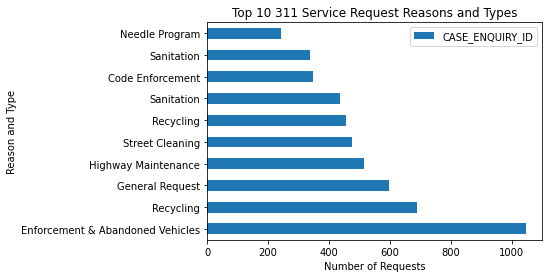

In [ ]:
# Count the number of requests for each reason and type
reason_counts = df.groupby(['REASON', 'TYPE'])['CASE_ENQUIRY_ID'].count().reset_index()
reason_counts = reason_counts.sort_values(by='CASE_ENQUIRY_ID', ascending=False).head(10)
reason_counts.plot(kind='barh', x='REASON', y='CASE_ENQUIRY_ID')
plt.title('Top 10 311 Service Request Reasons and Types')
plt.xlabel('Number of Requests')
plt.ylabel('Reason and Type')
plt.show()

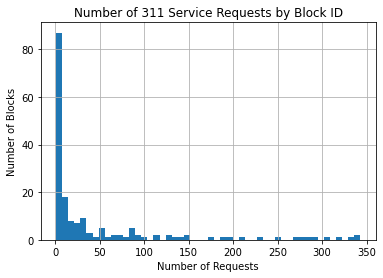

In [ ]:

# frequencies of open requests vs no of blocks
block_counts = df['BLOCK_ID'].value_counts()
block_counts.hist(bins=50)
plt.title('Number of 311 Service Requests by Block ID')
plt.xlabel('Number of Requests')
plt.ylabel('Number of Blocks')
plt.show()

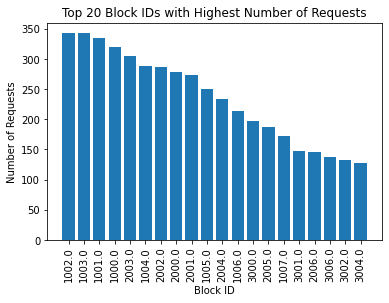

In [ ]:
# Calculate the number of requests for each block ID
blockid_counts = df["BLOCK_ID"].value_counts()

top20_blockids = blockid_counts.head(20)

plt.bar(top20_blockids.index.astype(str), top20_blockids.values)
plt.title('Top 20 Block IDs with Highest Number of Requests')
plt.xlabel('Block ID')
plt.ylabel('Number of Requests')
plt.xticks(rotation=90)
plt.show()

In [ ]:
df.columns

Index(['Unnamed: 0', 'CASE_ENQUIRY_ID', 'OPEN_DT', 'SUBJECT', 'REASON', 'TYPE',
       'LOCATION', 'propid', 'SOURCE', 'X', 'Y', 'LocationID', 'ObjectID',
       'TLID', 'BLK_ID_10', 'BG_ID_10', 'CT_ID_10', 'NSA_NAME', 'BRA_PD',
       'PUBLIC', 'HOUSING', 'UNCIVILUSE', 'BIGBUILD', 'GRAFFITI', 'TRASH',
       'PRIVATENEGLECT', 'PUBLICDENIG', 'PROBLEM', 'CLOSED_DT', 'BLOCK_ID',
       'DAY_OF_WEEK'],
      dtype='object')

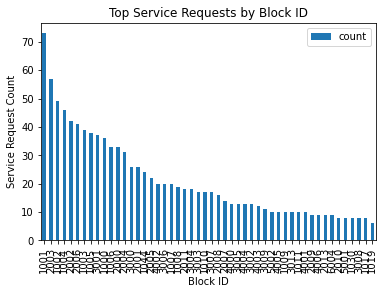

In [ ]:
# types - blocks - frequencies

df_filtered = df.groupby(['BLOCK_ID', 'TYPE']).size().reset_index(name='count')
df_filtered = df_filtered[df_filtered['count'] > 1]

idx = df_filtered.groupby(['BLOCK_ID'])['count'].transform(max) == df_filtered['count']
top_service_requests = df_filtered[idx].set_index('BLOCK_ID')
top_service_requests = top_service_requests.groupby('BLOCK_ID').first().sort_values(by='count', ascending=False)
# top_service_requests = top_service_requests.groupby('BLOCK_ID').first()
top_service_requests.index = top_service_requests.index.astype(int) 

top_service_requests.to_csv("/content/type_block_freq.csv")
ax = top_service_requests.head(50).plot.bar()

ax.set_xlabel('Block ID')
ax.set_ylabel('Service Request Count')
ax.set_title('Top Service Requests by Block ID')
plt.show()

In [ ]:
# df_filtered = df.groupby(['BLOCK_ID', 'REASON']).size().reset_index(name='count')
# df_filtered = df_filtered[df_filtered['count'] > 1]

# idx = df_filtered.groupby(['BLOCK_ID'])['count'].transform(max) == df_filtered['count']
# top_service_requests = df_filtered[idx].set_index('BLOCK_ID')
# top_service_requests = top_service_requests.groupby('BLOCK_ID').first().sort_values(by='count', ascending=False)
# top_service_requests.index = top_service_requests.index.astype(int) 

# top_service_requests.head(50).to_csv("/content/reason_block_freq.csv")

In [ ]:
# top_service_requests.groupby("TYPE").value_counts().head(20)

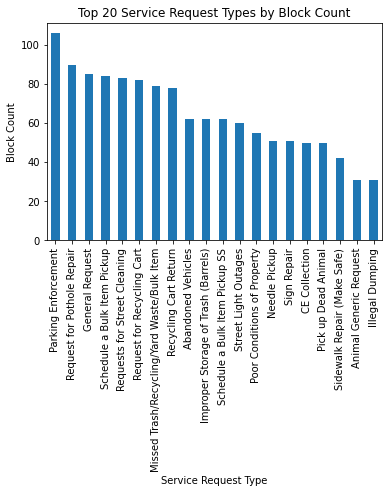

In [ ]:
import matplotlib.pyplot as plt

block_counts = df.groupby("TYPE")["BLOCK_ID"].nunique()
top_block_counts = block_counts.nlargest(20)
ax = top_block_counts.plot.bar()
ax.set_xlabel('Service Request Type')
ax.set_ylabel('Block Count')
ax.set_title('Top 20 Service Request Types by Block Count')

plt.show()
